In [ ]:
# 코랩 끊김 방지 코드 1
function ClickConnect(){
	console.log("Working"); 
	document.querySelector("colab-toolbar-button").click() 
} setInterval(ClickConnect, 1800000)

# 코랩 끊김 방지 코드 2
function ClickConnect()
{
console.log("Working");
document.querySelector("colab-connect-button").shadowRoot.getElementById('connect').click();
}
setInterval(ClickConnect,1800000);

# 코랩 로그 삭제
function CleanCurrentOutput(){ 
    var btn = document.querySelector(".output-icon.clear_outputs_enabled.output-icon-selected[title$='currently executing...'] iron-icon[command=clear-focused-or-selected-outputs]"); 
    if(btn) { console.log("clear log every 30 minutes");
     btn.click(); 
    } 
} 
setInterval(CleanCurrentOutput,1000*60*30);

# # 설치 후 런타임 재실행

In [1]:
# 한글 깨짐 방지, 나눔 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 파일 다운로드
!gdown "1OzqfK6K_bAFCr7rnR33Fj63W-lDiUtsQ&confirm=t"
!tar -xf 문서요약텍스트.tar
!rm 문서요약텍스트.tar

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/X11: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/X11/encodings: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/X11/encodings/large: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/X11/misc: caching, new cache contents: 89 fonts, 0 dirs
/usr/share/fonts/X11/util: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/fonts: caching, new cache contents: 34 fonts, 0 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/truetype/dejavu: caching, new cache contents: 6 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache content

In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices() # GPU Device 나오면 됨

# Pytorch 확인
import torch
torch.cuda.is_available() # True 나오면 됨

2023-01-13 03:44:58.098337: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-13 03:45:02.752447: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-13 03:45:04.335420: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /device:GPU:0 with 38420 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


False

# 1. 데이터 준비
- train : 325072 rows × 7 columns
- valid : 40134 rows × 7 columns

In [1]:
#@title Import
%autosave 300
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
# import tensorflow as tf
import glob, os, json
from datetime import datetime, timedelta
# from sklearn.metrics import classification_report, f1_score
# plt.rc('font', family='NanumBarunGothic')
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

Autosaving every 300 seconds


In [5]:
# 사용할 함수 정의

#   JsonToTsv() 함수
#   6개의 json 파일을 train, valid 2개의 csv로 저장하는 함수

#   ReadTsv() 함수
#   train.csv와 valid.csv 파일을 각각 df로 읽어오는 함수

# train.csv 와 valid.csv 를 저장할 gdrive 경로를 입력
# gdrive_path = '/content/drive/MyDrive/융합프로젝트_1조/텍스트요약/dataset/' # 코랩
# folder = '/content/문서요약텍스트'
gdrive_path = '/home/shinsoyeon926/text_summarization/dataset/' # 우분투 서버
folder = '/home/shinsoyeon926/text_summarization/문서요약텍스트'


def read_filenames(data):
    # json 파일들의 파일이름을 모두 불러온다
    paths = glob.glob(folder+'/*'+data+'_original.json')

    print(f'{data} 데이터 paths 목록')
    [print(path) for path in paths]
    print('-'*40)
    return paths


def read_json(path):
  filename = path.split('/')[3]

  # json 파일의 데이터를 읽어온다.
  with open(path, 'r') as f:
    json_data = json.load(f)
  print(f'데이터 읽기 성공 --- {filename}')
  return json_data


def make_df(json_data):
  # json 데이터를 DataFrame으로 만들기 
  id = []
  category = []
  char_count = []
  publish_date = []
  title = []
  text = []
  abstractive = []

  for article in json_data['documents']:
    id.append(article['id'])
    category.append(article['category'])
    char_count.append(article['char_count'])
    publish_date.append(article['publish_date'])
    title.append(article['title'])
    text.append(article['text'])
    abstractive.append(article['abstractive'])

  df = pd.DataFrame([id, category, char_count, publish_date, title, text, abstractive]).T
  df.columns = ['id', 'category', 'char_count', 'publish_date', 'title', 'text', 'abstractive']
  print(f'DataFrame으로 변환 성공')
  return df


def article_processing(df): # 뉴스 기사 원문 만들기

#   # 제목 앞에 "[사설]" 제거
#   for i, data in enumerate(df['title']): 
#     if '[사설]' in str(data)[:4]:
#       df['title'][i] = data.split('[사설]', 1)[1].strip()
#     else:
#       pass


  # 여러 문장으로 분리된 뉴스기사를 이어붙이는 반복문
  for i, texts in enumerate(df['text']): 
    sentences = [] # 뉴스 기사 문장들을 담을 리스트 생성
    for text in texts: # 문단 반복
      for data in text: # 문장 반복
        sentences.append(data['sentence']) # 분리된 문장들을 sentences 변수에 추가한다
    article  = ' '.join(sentences) # 각 문장을 띄어쓰기로 구문하여 한 문자열로 붙임

#     # 뉴스 맨 앞에 "[기자이름]" 제거
#     if ']' in article[:10]: 
#       article = article.split(']', 1)[1].strip()
#     else:
#       pass
    df['text'][i] = article


  # 요약문 가공 ( 리스트 형태를 문자열 형태로 변환하기)
  df['abstractive'] = [' '.join(text) for text in df['abstractive']]
  print(f'데이터 가공 완료, {len(df)} rows')
  return df


def save_df(dfs, data):
  result = pd.concat(dfs, ignore_index=True)
  result.to_csv(gdrive_path+data+'.csv', sep='\t')
  print(f'{data}.csv 저장 완료, {len(result)} rows')
  print('-'*40)
  return result


def JsonToTsv():
  dataset = ['train', 'valid']
  
  for data in dataset:
    paths = read_filenames(data)
    dfs = []

    for path in paths:
      json_data = read_json(path)
      df = make_df(json_data)
      df = article_processing(df)
      dfs.append(df)
      print('-'*40)
    save_df(dfs, data)   

def ReadTsv(): # train.csv와 valid.csv 파일이 존재하면 df로 읽어오는 함수
  dataset = ['train', 'valid']
  dfs = []
  for data in dataset:
    df = pd.read_csv(gdrive_path+data+'.csv', sep='\t', index_col=0, low_memory=False)
    dfs.append(df)
  return dfs[0], dfs[1]

In [6]:
# 6개의 json 파일을 읽어와 train, valid 두개의 csv로 저장하는 함수
JsonToTsv() # 소요시간 코랩 28분, 서버에서 15분

train 데이터 paths 목록
/home/shinsoyeon926/text_summarization/문서요약텍스트/사설_train_original.json
/home/shinsoyeon926/text_summarization/문서요약텍스트/신문기사_train_original.json
/home/shinsoyeon926/text_summarization/문서요약텍스트/법률_train_original.json
----------------------------------------
데이터 읽기 성공 --- text_summarization
DataFrame으로 변환 성공
데이터 가공 완료, 56760 rows
----------------------------------------
데이터 읽기 성공 --- text_summarization
DataFrame으로 변환 성공
데이터 가공 완료, 243983 rows
----------------------------------------
데이터 읽기 성공 --- text_summarization
DataFrame으로 변환 성공
데이터 가공 완료, 24329 rows
----------------------------------------
train.csv 저장 완료, 325072 rows
----------------------------------------
valid 데이터 paths 목록
/home/shinsoyeon926/text_summarization/문서요약텍스트/사설_valid_original.json
/home/shinsoyeon926/text_summarization/문서요약텍스트/신문기사_valid_original.json
/home/shinsoyeon926/text_summarization/문서요약텍스트/법률_valid_original.json
----------------------------------------
데이터 읽기 성공 --- text_summarization
DataFrame으

In [7]:
# train 데이터셋과 valid 데이터셋을 DataFrame으로 받아옴

train, valid = ReadTsv() 

In [12]:
train.head()
valid.head()

,id,category,char_count,publish_date,title,text,abstractive
0,100062073,오피니언,1153,2011-09-01 00:03:01,[사설] 기부문화 확산 은근히 강조한 李대통령,"이명박 대통령이 어제 30대 그룹 총수를 모아놓고 ""시대적 요구는 역시 총수가 앞장...",이명박 대통령은 어제 30대 그룹 총수를 모아놓고 시대적 요구는 역시 총수가 앞장서...
1,100062076,오피니언,1229,2011-09-01 00:01:01,[사설] `류우익 對北전략` 지킬것과 바꿀것 확실히해야,이명박 정부의 첫 대통령실장을 지낸 류우익 주중대사가 통일부 장관에 내정되면서 대북...,류우억 주중대사가 통일부 장관에 내정되면서 대북정책에 대하여 일관성 있게 지켜야...
2,100062209,증권,1164,2011-09-01 00:04:00,"[사설] 한은법 개정, 이젠 금융위기 대응력 높일 때",한국은행법 개정안이 우여곡절 끝에 국회 본회의를 통과했다. 이 법안은 글로벌 금융위...,한국은행은 금융 위기 이후 금융 시스템 안정을 위해 권한이 더욱 부여된 개정안을 통...
3,100062217,증권,1153,2011-09-01 00:03:00,[사설] 기부문화 확산 은근히 강조한 李대통령,"이명박 대통령이 어제 30대 그룹 총수를 모아놓고 ""시대적 요구는 역시 총수가 앞장...",30대 그룹 총수들을 모아 회동을 가진 이명박 대통령은 간접적으로 기부에 대해 언급...
4,100062218,증권,1098,2011-09-01 00:02:00,[사설] 포퓰리즘식 비정규직 보호 得보다 失이 크다,한나라당과 정부가 비정규직 대책을 이르면 다음주 중 내놓을 예정이다. 비정규직 임금...,내년 총선ㆍ대선을 앞두고 한나라당의 비정규직을 대상으로 한 포퓰리즘 대책들은 정치권...


,id,category,char_count,publish_date,title,text,abstractive
0,365247698,종합,1171,2019-10-31 04:40:00,"[사설] 이해찬 대표 ‘조국 사태’ 사과, 과감한 인적 쇄신으로 이어져야",더불어민주당 이해찬 대표가 30 일 오후 국회에서 기자간담회를 열고 조국 전 법무부...,이해찬 대표가 조국 사태와 관련 송구한 입장 표명이 과감한 인적 쇄신으로 이어져야 한다.
1,365247823,정치,1122,2019-10-31 05:00:00,"[사설] ""전기료 인상 절대 없다""던 약속 누가 책임지나",탈원전 정책에서 비롯된 한국전력의 경영 부담이 결국 전기료 인상을 초래하게 됐다. ...,탈원전 정책에서 비롯된 한국전력의 경영 악화가 결국 전기료 인상이라는 결과를 낳아 ...
2,365247824,정치,1113,2019-10-31 05:00:00,[사설] 언제까지 북한 억지에 끌려다닐 건가,북한이 그제 금강산국제관광국 명의로 통일부와 현대아산에 통지문을 보내 금강산관광 시...,북한이 통일부와 현대아산에 금강산 관광 시설 철거와 관련하여 문서 교환 방식의 협의...
3,365247941,종합,1409,2019-10-31 05:00:00,"[사설] 물가상승 OECD 최저, 뚜렷해진 디플레 조짐",지난달 한국의 소비자물가상승률이 경제협력개발기구(OECD) 회원국 중 가장 낮았다....,OECD가 집계한 소비자물가 통게에서 9월 한국 상승률은 전년 동월 대비 -0.4%...
4,365250721,종합,1025,2019-10-31 06:30:00,"[사설]'탈원전 재앙', 결국 국민 전기료 부담만 늘린다",김종갑 한국전력 사장이 1 조1 천억원이 넘는 각종 전기료 특례 할인을 모두 폐지하...,김종갑 한국전력 사장이 1조 1천억원 규모의 전기료 특례 할인 폐지 및 전기요금 원...


# 2. 데이터 EDA & 전처리
- NaN, null 값 확인
- title, text, abstractive 글자수 최소/최대 값 확인
- 글자수 너무 적거나 많은 이상치 값 확인
- 기사 title 맨 앞에 [사설] 삭제 -> 안하기로함
- 기사 text 맨 앞에 [기자이름] 삭제 -> 안하기로함


In [9]:
train.info()
print()
valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325072 entries, 0 to 325071
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            325072 non-null  object
 1   category      324725 non-null  object
 2   char_count    325072 non-null  int64 
 3   publish_date  325072 non-null  object
 4   title         325061 non-null  object
 5   text          325072 non-null  object
 6   abstractive   325064 non-null  object
dtypes: int64(1), object(6)
memory usage: 19.8+ MB

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40134 entries, 0 to 40133
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            40134 non-null  int64 
 1   category      40119 non-null  object
 2   char_count    40134 non-null  int64 
 3   publish_date  40134 non-null  object
 4   title         40134 non-null  object
 5   text          40134 non-null  object
 6   ab

In [10]:
# 결측치 확인

train.isna().sum()
print()
train.isnull().sum()
print()
valid.isna().sum()
print()
valid.isnull().sum()


# category        347
# title            11
# abstractive       8

# category        15
# abstractive      1

id                0
category        347
char_count        0
publish_date      0
title            11
text              0
abstractive       8
dtype: int64

id                0
category        347
char_count        0
publish_date      0
title            11
text              0
abstractive       8
dtype: int64

id               0
category        15
char_count       0
publish_date     0
title            0
text             0
abstractive      1
dtype: int64

id               0
category        15
char_count       0
publish_date     0
title            0
text             0
abstractive      1
dtype: int64

In [13]:
# 결측치 처리

# 요약문이 없는 8개 행들은 삭제
train.dropna(inplace=True, subset=['abstractive'])
valid.dropna(inplace=True, subset=['abstractive'])

# 카테고리와 제목이 없는 행들은 " " 문자열로 변환
train.fillna("", inplace=True)
valid.fillna("", inplace=True)

In [14]:
# 결측치 처리 후 확인
train.isna().sum()
print()
train.isnull().sum()
print()
valid.isna().sum()
print()
valid.isnull().sum()

id              0
category        0
char_count      0
publish_date    0
title           0
text            0
abstractive     0
dtype: int64

id              0
category        0
char_count      0
publish_date    0
title           0
text            0
abstractive     0
dtype: int64

id              0
category        0
char_count      0
publish_date    0
title           0
text            0
abstractive     0
dtype: int64

id              0
category        0
char_count      0
publish_date    0
title           0
text            0
abstractive     0
dtype: int64

In [15]:
# 글자수 컬럼 만들기
train['len_text'] = [ len(text) for text in train['text'] ]
train['len_abstractive'] = [ len(text) for text in train['abstractive'] ]

valid['len_text'] = [ len(text) for text in valid['text'] ]
valid['len_abstractive'] = [ len(text) for text in valid['abstractive'] ]
train.head()
valid.head()

,id,category,char_count,publish_date,title,text,abstractive,len_text,len_abstractive
0,100062073,오피니언,1153,2011-09-01 00:03:01,[사설] 기부문화 확산 은근히 강조한 李대통령,"이명박 대통령이 어제 30대 그룹 총수를 모아놓고 ""시대적 요구는 역시 총수가 앞장...",이명박 대통령은 어제 30대 그룹 총수를 모아놓고 시대적 요구는 역시 총수가 앞장서...,1133,153
1,100062076,오피니언,1229,2011-09-01 00:01:01,[사설] `류우익 對北전략` 지킬것과 바꿀것 확실히해야,이명박 정부의 첫 대통령실장을 지낸 류우익 주중대사가 통일부 장관에 내정되면서 대북...,류우억 주중대사가 통일부 장관에 내정되면서 대북정책에 대하여 일관성 있게 지켜야...,1205,122
2,100062209,증권,1164,2011-09-01 00:04:00,"[사설] 한은법 개정, 이젠 금융위기 대응력 높일 때",한국은행법 개정안이 우여곡절 끝에 국회 본회의를 통과했다. 이 법안은 글로벌 금융위...,한국은행은 금융 위기 이후 금융 시스템 안정을 위해 권한이 더욱 부여된 개정안을 통...,1140,103
3,100062217,증권,1153,2011-09-01 00:03:00,[사설] 기부문화 확산 은근히 강조한 李대통령,"이명박 대통령이 어제 30대 그룹 총수를 모아놓고 ""시대적 요구는 역시 총수가 앞장...",30대 그룹 총수들을 모아 회동을 가진 이명박 대통령은 간접적으로 기부에 대해 언급...,1133,102
4,100062218,증권,1098,2011-09-01 00:02:00,[사설] 포퓰리즘식 비정규직 보호 得보다 失이 크다,한나라당과 정부가 비정규직 대책을 이르면 다음주 중 내놓을 예정이다. 비정규직 임금...,내년 총선ㆍ대선을 앞두고 한나라당의 비정규직을 대상으로 한 포퓰리즘 대책들은 정치권...,1078,123


,id,category,char_count,publish_date,title,text,abstractive,len_text,len_abstractive
0,365247698,종합,1171,2019-10-31 04:40:00,"[사설] 이해찬 대표 ‘조국 사태’ 사과, 과감한 인적 쇄신으로 이어져야",더불어민주당 이해찬 대표가 30 일 오후 국회에서 기자간담회를 열고 조국 전 법무부...,이해찬 대표가 조국 사태와 관련 송구한 입장 표명이 과감한 인적 쇄신으로 이어져야 한다.,1110,49
1,365247823,정치,1122,2019-10-31 05:00:00,"[사설] ""전기료 인상 절대 없다""던 약속 누가 책임지나",탈원전 정책에서 비롯된 한국전력의 경영 부담이 결국 전기료 인상을 초래하게 됐다. ...,탈원전 정책에서 비롯된 한국전력의 경영 악화가 결국 전기료 인상이라는 결과를 낳아 ...,1074,138
2,365247824,정치,1113,2019-10-31 05:00:00,[사설] 언제까지 북한 억지에 끌려다닐 건가,북한이 그제 금강산국제관광국 명의로 통일부와 현대아산에 통지문을 보내 금강산관광 시...,북한이 통일부와 현대아산에 금강산 관광 시설 철거와 관련하여 문서 교환 방식의 협의...,1062,133
3,365247941,종합,1409,2019-10-31 05:00:00,"[사설] 물가상승 OECD 최저, 뚜렷해진 디플레 조짐",지난달 한국의 소비자물가상승률이 경제협력개발기구(OECD) 회원국 중 가장 낮았다....,OECD가 집계한 소비자물가 통게에서 9월 한국 상승률은 전년 동월 대비 -0.4%...,1365,181
4,365250721,종합,1025,2019-10-31 06:30:00,"[사설]'탈원전 재앙', 결국 국민 전기료 부담만 늘린다",김종갑 한국전력 사장이 1 조1 천억원이 넘는 각종 전기료 특례 할인을 모두 폐지하...,김종갑 한국전력 사장이 1조 1천억원 규모의 전기료 특례 할인 폐지 및 전기요금 원...,1008,138


(array([1., 0., 0., ..., 0., 0., 1.]),
 array([   67.    ,    68.4725,    69.945 , ..., 14789.055 , 14790.5275,
        14792.    ]),
 <BarContainer object of 10000 artists>)

(0.0, 1500.0)

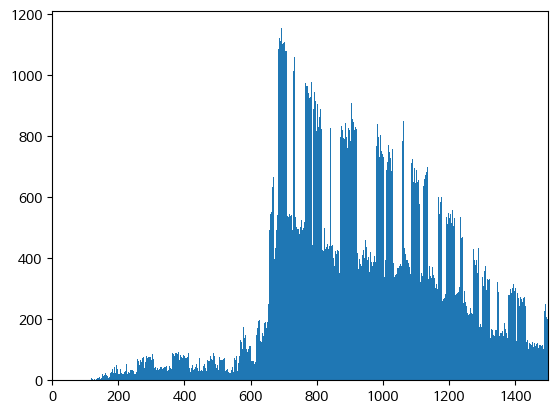

In [10]:
# train 기사 원문 빈도수 히스토그램
plt.hist(train['len_text'], bins=10000)
plt.xlim(0, 1500)

In [14]:
# 글자수 컬럼 이상치 확인하기

train[['len_text', 'len_abstractive']].describe()
valid[['len_text', 'len_abstractive']].describe()
# train 기사 글자수 평균 : 1010,   요약문 글자수 평균 : 133,  25% : 774,  75%: 1199
# valid 기사 글자수 평균 : 1011,   요약문 글자수 평균 : 138,  25% : 780,  75%: 1203

,len_text,len_abstractive
count,325064.000000,325064.000000
mean,1920.346018,132.839641
std,686.188639,44.460161
min,281.000000,10.000000
25%,1414.000000,104.000000
50%,1810.000000,126.000000
75%,2321.000000,154.000000
max,29752.000000,1000.000000


,len_text,len_abstractive
count,40133.000000,40133.000000
mean,1889.650861,137.674732
std,657.291317,42.597415
min,307.000000,33.000000
25%,1408.000000,109.000000
50%,1849.000000,132.000000
75%,2294.000000,160.000000
max,6830.000000,726.000000


,id,category,char_count,publish_date,title,text,abstractive,len_text,len_abstractive


In [30]:
 # 75% 이상인 이상치행은 학습데이터에서 제외 (안하기로함)
    
# train = train[train['len_text']<=1199]
# valid = valid[valid['len_text']<=1203]

In [17]:
# 전처리 완료된 데이터를 csv로 저장

save_df([train], 'train') # train 데이터를 train.csv로 저장
save_df([valid], 'valid') # valid 데이터를 valid.csv로 저장

valid.csv 저장 완료, 40133 rows
----------------------------------------


,id,category,char_count,publish_date,title,text,abstractive,len_text,len_abstractive
0,365247698,종합,1171,2019-10-31 04:40:00,"[사설] 이해찬 대표 ‘조국 사태’ 사과, 과감한 인적 쇄신으로 이어져야",더불어민주당 이해찬 대표가 30 일 오후 국회에서 기자간담회를 열고 조국 전 법무부...,이해찬 대표가 조국 사태와 관련 송구한 입장 표명이 과감한 인적 쇄신으로 이어져야 한다.,1110,49
1,365247823,정치,1122,2019-10-31 05:00:00,"[사설] ""전기료 인상 절대 없다""던 약속 누가 책임지나",탈원전 정책에서 비롯된 한국전력의 경영 부담이 결국 전기료 인상을 초래하게 됐다. ...,탈원전 정책에서 비롯된 한국전력의 경영 악화가 결국 전기료 인상이라는 결과를 낳아 ...,1074,138
2,365247824,정치,1113,2019-10-31 05:00:00,[사설] 언제까지 북한 억지에 끌려다닐 건가,북한이 그제 금강산국제관광국 명의로 통일부와 현대아산에 통지문을 보내 금강산관광 시...,북한이 통일부와 현대아산에 금강산 관광 시설 철거와 관련하여 문서 교환 방식의 협의...,1062,133
3,365247941,종합,1409,2019-10-31 05:00:00,"[사설] 물가상승 OECD 최저, 뚜렷해진 디플레 조짐",지난달 한국의 소비자물가상승률이 경제협력개발기구(OECD) 회원국 중 가장 낮았다....,OECD가 집계한 소비자물가 통게에서 9월 한국 상승률은 전년 동월 대비 -0.4%...,1365,181
4,365250721,종합,1025,2019-10-31 06:30:00,"[사설]'탈원전 재앙', 결국 국민 전기료 부담만 늘린다",김종갑 한국전력 사장이 1 조1 천억원이 넘는 각종 전기료 특례 할인을 모두 폐지하...,김종갑 한국전력 사장이 1조 1천억원 규모의 전기료 특례 할인 폐지 및 전기요금 원...,1008,138
...,...,...,...,...,...,...,...,...,...
40128,99978,형사,352,19841211,"공문서위조,보호감호,위조공문서행사,특정범죄가중처벌등에관한법률위반",가. 특정범죄가중처벌등에관한법률 제5조의4 제5항의 취지는 동항 해당의 경우에는 상...,특정범죄가중처벌등에관한 법률 제5조의4 제1항 소정의 상습범으로 기소된 공소사실에서...,346,233
40129,99979,형사,280,19841211,절도,자정 가까운 시간에 점포를 폐점하면서 제조 년월일이 오래된 빵을 별다른 감수조치를 ...,피해자가 자정 가까운 시간에 점포 폐점으로 오래된 빵을 별 다른 주의의무 없이 점포...,275,217
40130,99987,민사,199,19841226,전부금,가옥의 전세나 임대차계약에 있어서의 전세보증금은 특별한 사정이 없는 한 임차인의 임...,전세나 임대차계약에 있어 전세보증금은 특별한 사정이 없다면 임차인의 임차가옥 명도와...,194,172
40131,99994,특허,418,19841226,거절사정,"출원상표와 인용상표는 그 외관에 있어서는 전체적으로 볼 때 상이하나, 호칭에 있어서...",출원상표와 인용상표는 외관적으로는 전체적으로 다르게 보이지만 호칭에 있어서는 거래계...,413,207
